In [ ]:
# Importing required libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense

In [2]:
# Load the Iris dataset

data = load_iris()
X = data.data  # Features
y = data.target.reshape(-1, 1)  # Labels

In [3]:
# One-hot encode labels

encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y)

# Print first 5 labels before and after encoding

print("First 5 original labels:", y[:5].flatten())
print("First 5 one-hot encoded labels:\n", y_one_hot[:5])

First 5 original labels: [0 0 0 0 0]
First 5 one-hot encoded labels:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [4]:
# Split dataset into train (70%), validation (10%), and test (20%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Print dataset shapes

print(f"Original dataset shape: {X.shape}, Labels shape: {y.shape}")
print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Labels shape: {y_test.shape}")

Original dataset shape: (150, 4), Labels shape: (150, 1)
Training set shape: (105, 4), Labels shape: (105, 3)
Validation set shape: (15, 4), Labels shape: (15, 3)
Test set shape: (30, 4), Labels shape: (30, 3)


In [5]:
# Normalize feature values to [0,1]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [6]:
# Define MLP model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [7]:
# Compile model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Train model and store history

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6407 - loss: 0.8863 - val_accuracy: 0.8667 - val_loss: 0.6284
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6132 - loss: 0.8523 - val_accuracy: 0.8667 - val_loss: 0.5982
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6261 - loss: 0.8303 - val_accuracy: 0.8667 - val_loss: 0.5712
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6514 - loss: 0.8097 - val_accuracy: 0.8667 - val_loss: 0.5463
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6604 - loss: 0.7732 - val_accuracy: 0.8667 - val_loss: 0.5239
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6604 - loss: 0.7555 - val_accuracy: 0.8667 - val_loss: 0.5034
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6448 - loss: 0.7556 - val_accuracy: 0.8667 - val_loss: 0.4846
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6924 - loss: 0.7009 - val_accuracy: 0.8667 - val_loss: 0.4673

In [9]:
# Evaluate on test data

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [10]:
# Compute metrics

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.7333
Test Precision: 0.8222
Test Recall: 0.7576
Test F1 Score: 0.6883


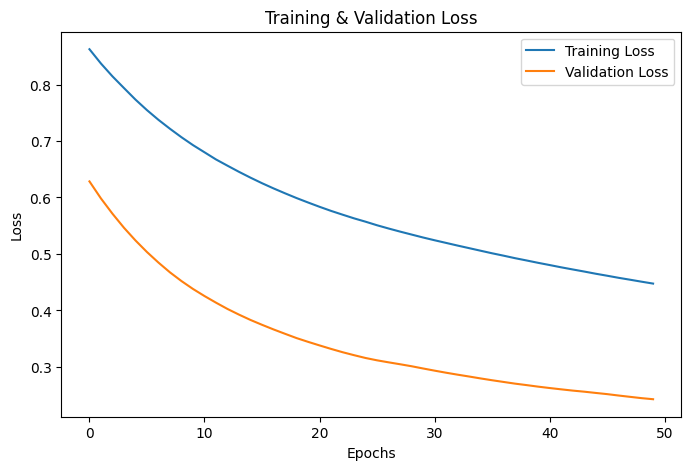

In [11]:
# Plot training & validation loss

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

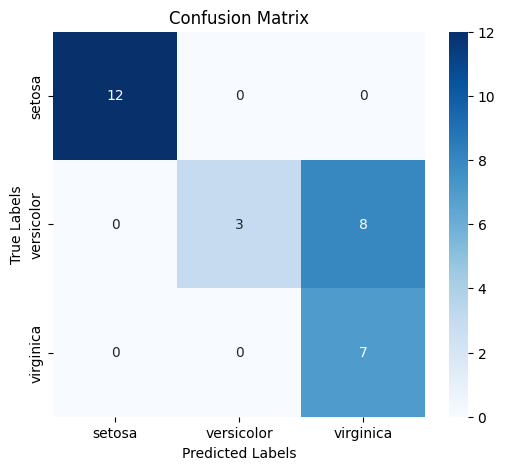

In [12]:
# Plot confusion matrix

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
!pip install wandb


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
# Initialize W&B

wandb.init(project="iris_mlp", name="experiment_1", config={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "hidden_layer_size": 16,
    "architecture": [
        {"layer": "Input", "units": 4},
        {"layer": "Dense", "units": 16, "activation": "relu"},
        {"layer": "Dense", "units": 3, "activation": "softmax"}
    ]
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: darpana (darpana-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
# Access the configuration

config = wandb.config

# Define the model

model = Sequential([
    Input(shape=(4,)),
    Dense(config.hidden_layer_size, activation='relu'),
    Dense(3, activation='softmax')
])

In [17]:
# Compile the model

model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model 

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=config.batch_size,
    epochs=config.epochs,
    callbacks=[
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="model-checkpoints/model.keras")
    ]
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - accuracy: 0.3438 - loss: 1.19 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.2966 - loss: 1.2068 - val_accuracy: 0.4667 - val_loss: 1.0593
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3125 - loss: 1.198 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3149 - loss: 1.1816 - val_accuracy: 0.4667 - val_loss: 1.0149
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3125 - loss: 1.127 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.3545 - loss: 1.1322 - val_accuracy: 0.4667 - val_loss: 0.9725
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4062 - loss: 1.080 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.3708 - loss: 1.1060 - val_accuracy: 0.4667 - val_loss: 0.9325
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5312 - loss: 1.010 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.4118 - loss: 1.0708 - val_accuracy: 0.6000 - val_loss: 0.8951
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━

In [19]:
# Evaluate the model

test_loss, test_accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6667 - loss: 0.492 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6667 - loss: 0.4923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [20]:
# Log final evaluation metrics

wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
})

In [21]:
# Log confusion matrix

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.close()

In [22]:
# Log loss curves

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
wandb.log({"loss_curves": wandb.Image(plt)})
plt.close()

In [24]:
# Finish the W&B run

wandb.finish()

epoch/accuracy,▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▃▅▆▇▇▇██████████████████████████████
epoch/val_loss,██▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
f1_score,▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
